In [1]:
from monitorlib import load_pcdata
import pandas as pd

def sync_positions(data,sample,i):
     # Searching for the cursor position that it is nearest to screenshot timestamp ti 
     # (before or after, it does not matter)
     ti = data[sample]['screenshots']['timestamp'][i]
     abs_diff = abs(data[sample]['moves']['timestamp'] - ti)
     closest_index = abs_diff.idxmin()
     px, py = data[sample]['moves']['px'][closest_index], data[sample]['moves']['py'][closest_index]
     return px, py

def sync_MKevents(sample_df, data, sample):
     
     def set_value(sample_df, tdiff, event, position=None):
          # Searching for the screenshot immediately before to the M&K event timestamp ti
          closest_index = abs(tdiff[tdiff <= 0]).idxmin()
          if sample_df['mouse_keyboard'][closest_index] != None:
               print('colision between M&K events', sample_df['mouse_keyboard'][closest_index], event)   # what to do?
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          else:
               sample_df.loc[closest_index, 'mouse_keyboard'] = event
          if position != None:
               sample_df.loc[closest_index, 'px'] = position[0]
               sample_df.loc[closest_index, 'py'] = position[1]
          
     # Initial values
     sample_df['mouse_keyboard'] = [None for i in range(len(sample_df))]
     timestamps_df = data[sample]['screenshots']['timestamp']

     # Clicks
     for i in range(len(data[sample]['clicks'])):
          ti = data[sample]['clicks']['timestamp'][i]
          button = data[sample]['clicks']['button'][i]
          click_px, click_py = data[sample]['clicks']['px'][i], data[sample]['clicks']['py'][i]
          set_value(sample_df, timestamps_df - ti, button, (click_px,click_py))

     # Scrolls
     for i in range(len(data[sample]['scrolls'])):
          ti = data[sample]['scrolls']['timestamp'][i]
          dy = data[sample]['scrolls']['dy'][i] 
          scroll_px, scroll_py = data[sample]['scrolls']['px'][i], data[sample]['scrolls']['py'][i]
          if dy == 1:
               scroll = 'scroll_down' 
          elif dy == -1:
               scroll = 'scroll_up'
          else:
               scroll = 'what?_scroll'
          set_value(sample_df, timestamps_df - ti, scroll, (scroll_px, scroll_py))
   
     # Keyboard events
     for i in range(len(data[sample]['keys'])):
          ti = data[sample]['keys']['timestamp'][i]
          key = data[sample]['keys']['key'][i].strip("'")
          set_value(sample_df, timestamps_df - ti, key)

def sync(data):
     samples = []
     for sample in data.keys():
          print(f'processing {sample}')
          sample_df = pd.DataFrame()
          sample_df['img_path'] = [img_path for img_path in data[sample]['screenshots']['img_path']]
          
          # Sync cursor positions to screenshots
          positions = [sync_positions(data,sample,i) for i in range(len(data[sample]['screenshots']))]
          sample_df['px'] = [px for px, _ in positions]
          sample_df['py'] = [py for _, py in positions]

          # Sync mouse and keyboard events to screenshots
          sync_MKevents(sample_df, data, sample)

          samples.append(sample_df)
     return samples

data = load_pcdata('data') 

# Syncronization. Order in time: 1) M&K Events, 2) Screenshoots and 3) Cursor positions 
samples = sync(data)

# Replace None values with a string
for sample in samples:
    sample.fillna("no_action",inplace=True)

# tokenization
tokens = set()
for sample in samples:
    tokens.update(sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
print(len(tokens))
print(tokens)

# Add timestamp column
for sample in samples:
    sample['time'] = sample['img_path'].map(lambda x: float(x.split('/')[2].split('_')[-1].split('.jpg')[0]))

samples[0]

processing sample1
processing sample2
processing sample3
processing sample4
colision between M&K events scroll_down scroll_down
processing sample5
processing sample6
processing sample7
7
['Button.left', 'Key.enter', 'Key.esc', 'no_action', 'o', 'scroll_down', 'z']


,img_path,px,py,mouse_keyboard,time
0,data/sample1/0000000000_0.04096198081970215.jpg,570,428,no_action,0.040962
1,data/sample1/0000000001_0.12202715873718262.jpg,570,428,no_action,0.122027
2,data/sample1/0000000002_0.19535470008850098.jpg,570,428,no_action,0.195355
3,data/sample1/0000000003_0.26665711402893066.jpg,570,428,no_action,0.266657
4,data/sample1/0000000004_0.3381388187408447.jpg,570,428,no_action,0.338139
...,...,...,...,...,...
726,data/sample1/0000000726_50.409887075424194.jpg,1360,300,no_action,50.409887
727,data/sample1/0000000727_50.47743463516235.jpg,1360,300,no_action,50.477435
728,data/sample1/0000000728_50.54669976234436.jpg,1360,300,no_action,50.546700
729,data/sample1/0000000729_50.616905212402344.jpg,1360,300,no_action,50.616905


In [2]:
import numpy as np

# Extract just actions 
a_samples = []
for sample in samples: 
    actions_df = sample[sample['mouse_keyboard'] != 'no_action'].copy()
    delays = actions_df['time'][1:].values - actions_df['time'][0:-1].values
    delays = np.append(delays,0.0)
    actions_df['delay'] = delays
    actions_df = actions_df.reset_index(drop=True)
    a_samples.append(actions_df)
    
for a_sample in a_samples:
    print(len(a_sample))

a_samples[2]

18
17
15
21
15
18
18


,img_path,px,py,mouse_keyboard,time,delay
0,data/sample3/0000000021_1.5856506824493408.jpg,35,135,Button.left,1.585651,1.562890
1,data/sample3/0000000043_3.148540496826172.jpg,369,118,z,3.148540,0.137333
2,data/sample3/0000000045_3.2858736515045166.jpg,369,118,o,3.285874,0.138859
3,data/sample3/0000000047_3.424732208251953.jpg,369,118,o,3.424732,0.397115
4,data/sample3/0000000053_3.821847677230835.jpg,367,119,Key.enter,3.821848,3.082767
5,data/sample3/0000000098_6.904615163803101.jpg,1320,798,Button.left,6.904615,3.271739
6,data/sample3/0000000145_10.176353693008423.jpg,887,540,Button.left,10.176354,5.685507
7,data/sample3/0000000226_15.861860275268555.jpg,1036,565,Button.left,15.861860,2.550357
8,data/sample3/0000000262_18.412216901779175.jpg,1110,282,Button.left,18.412217,1.310360
9,data/sample3/0000000280_19.72257685661316.jpg,1077,732,Button.left,19.722577,6.116127


In [3]:
# tokenization
tokens = set()
for a_sample in a_samples:
    tokens.update(a_sample['mouse_keyboard'].unique().tolist())
tokens = list(tokens)
tokens.sort()
tokens.insert(0,'no_action')
print(len(tokens))
print(tokens)

7
['no_action', 'Button.left', 'Key.enter', 'Key.esc', 'o', 'scroll_down', 'z']


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,4, stride=2, padding="valid")
        self.conv2 = nn.Conv2d(32,64,4, stride=2, padding="valid")
        self.conv3 = nn.Conv2d(64,128,4, stride=2, padding="valid")
        self.conv4 = nn.Conv2d(128,256,4, stride=2, padding="valid")
        self.fc_mean = nn.Linear(256*2*2, latent_dims)
        self.fc_logvar = nn.Linear(256*2*2, latent_dims)

        self.N = torch.distributions.normal.Normal(torch.tensor(0.0).to(device), 
                                                   torch.tensor(1.0).to(device))
        self.kl = 0
    
    def forward(self, x):
        #x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        z_mu = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        z_sigma = torch.exp(0.5*z_logvar)
        
        z = z_mu + z_sigma*self.N.sample(z_mu.shape)
        self.kl = 0.5*(z_sigma**2 + z_mu**2 - z_logvar - 1).sum()
        return z, z_mu, z_sigma

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Unflatten(1,(1024,1,1)),
            nn.ConvTranspose2d(1024,128,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,5, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32,6, stride=2, padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,3,6, stride=2, padding=0),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.decoder(x)

class Vae(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        # x = x.to(device)
        z, _, _ = self.encoder(x)
        return self.decoder(z)

import torch

SEED = 0
d = 32

torch.manual_seed(SEED)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'device: {device}')

device = "cpu"
vae = Vae(latent_dims=d)
vae.to(device)
vae.load_state_dict(torch.load('best_vae.pt')['model_state_dict'])
vae.eval()
vae.encoder

Encoder(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=valid)
  (fc_mean): Linear(in_features=1024, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=32, bias=True)
)

In [5]:
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

IMGSIZE= [64,64] #[1080//10, 1920//10]
img_transform = transforms.Compose([
                transforms.Resize(IMGSIZE, antialias=None),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5]),
                
                ])

for a_sample in tqdm(a_samples): 
    zmu_list, zsigma_list = [], []
    for i, img_path in enumerate(a_sample["img_path"]):
        image = Image.open(img_path)
        image = img_transform(image)
        with torch.no_grad():
            _, zmu, zsigma = vae.encoder(torch.unsqueeze(image, 0))
        zmu_list.append(zmu[0].numpy())
        zsigma_list.append(zsigma[0].numpy())
    a_sample['mu'] = zmu_list
    a_sample['sigma'] = zsigma_list

/home/ezamorag/miniconda3/envs/automat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 7/7 [00:01<00:00,  4.45it/s]


In [7]:
# model design
# Inputs = (screenshot features with AE) 
# Outputs = (M&K action, mouse position, delay)

from torch.utils.data import Dataset
import torch
import torchvision
import torch.nn.functional as F

def normalization(x, max):
    return 2.0*(x/max) - 1.0

class PCDataset(Dataset):
    def __init__(self, samples, root_dir, tokens):
        self.samples = samples
        self.root_dir = root_dir
        self.tokens = tokens
        self.maxtokens = len(tokens)
        self.maxdelay = None
        self.maxlength = None
        self.maxwidth_screenshoot = None
        self.maxheight_screenshoot = None
        self.N = torch.distributions.normal.Normal(torch.tensor(0.0), 
                                                   torch.tensor(1.0))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features_list, action_list, position_list, delay_list, = [], [], [], []
        for i, img_path in enumerate(self.samples[idx]["img_path"]):
            # Image features. Ideal [-inf,inf] - Approx (-4,4)
            z_mu = torch.tensor(self.samples[idx]["mu"][i])
            z_sigma = torch.tensor(self.samples[idx]["sigma"][i])
            img_features = z_mu #+ z_sigma*self.N.sample(z_mu.shape)
            features_list.append(img_features)

            # Mouse-keyboard action [one_hot]
            action_index = self.tokens.index(self.samples[idx]["mouse_keyboard"][i])
            action = F.one_hot(torch.tensor(action_index), num_classes=self.maxtokens)
            action_list.append(action)

            # Mouse position [-1,1]
            px = self.samples[idx]["px"][i]
            py = self.samples[idx]["py"][i]
            norm_position = torch.tensor([normalization(px, max=self.maxwidth_screenshoot), 
                              normalization(py, max=self.maxheight_screenshoot)]
                            ) 
            position_list.append(norm_position)
            
            # Delay [0,inf)
            delay = self.samples[idx]["delay"][i]
            norm_delay = torch.tensor([delay/self.maxdelay])
            delay_list.append(norm_delay)

        ### Padding
        padding_dims = self.maxlength-len(features_list)
            # Image features
        features_list.extend(torch.zeros(torch.Size([padding_dims]) + img_features.shape))
        x = torch.stack(features_list, 0).type(torch.FloatTensor)
            # Mouse-keyboard action
        action_padding = padding_dims*[self.tokens.index('no_action')]
        action_padding = F.one_hot(torch.tensor(action_padding), num_classes=self.maxtokens)
        action_list.extend(action_padding)     
        y_action = torch.stack(action_list, 0).type(torch.FloatTensor)

            # Mouse position 
        position_list.extend(torch.zeros(torch.Size([padding_dims]) + norm_position.shape))    
        y_position = torch.stack(position_list, 0).type(torch.FloatTensor)
            # Delay
        delay_list.extend(torch.zeros(torch.Size([padding_dims]) + norm_delay.shape))    
        y_delay = torch.stack(delay_list, 0).type(torch.FloatTensor)

        return x, [y_action, y_position, y_delay] 
    
dataset = PCDataset(a_samples, root_dir='./', tokens=tokens)
dataset.maxlength = 25  #steps in time
dataset.maxwidth_screenshoot = 1920  #pixels
dataset.maxheight_screenshoot = 1080 #pixels
dataset.maxdelay = 15 #secs

traindata, valdata = torch.utils.data.random_split(dataset,[5, 2])
trainloader = torch.utils.data.DataLoader(traindata, batch_size=5, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(valdata, batch_size=2, shuffle=False, num_workers=10)

torch.Size([2, 25, 32]) torch.Size([2, 25, 7]) torch.Size([2, 25, 2]) torch.Size([2, 25, 1])


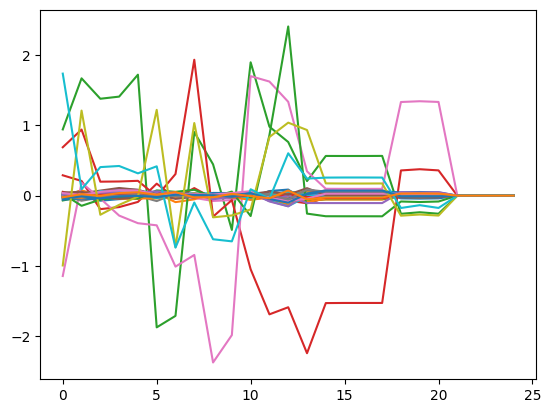

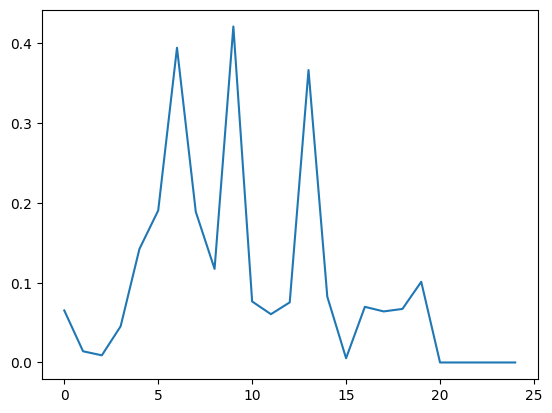

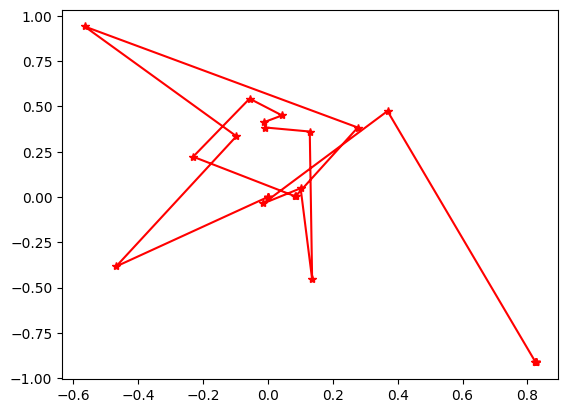

torch.float32


tensor([[[0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0

In [8]:
x0, (y1, y2, y3) = next(iter(valloader))
print(x0.shape, y1.shape, y2.shape, y3.shape)

import matplotlib.pyplot as plt

plt.plot(x0[0,:,:])
plt.show()
plt.plot(y3[0,:,0])
plt.show()
plt.plot(y2[0,:,0], y2[0,:,1], 'r-*')
plt.show()

print(y1.dtype)
y1

In [138]:
import torch.nn.functional as F

class LSTM9(nn.Module):  
    def __init__(self, z_dim, h_dim, num_actions, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(z_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.fc_action = nn.Linear(h_dim, num_actions)
        self.fc_position = nn.Linear(h_dim, 2)
        self.fc_delay = nn.Linear(h_dim, 1)

    def forward(self, zt):
        ht, _ = self.lstm(zt)  # (N, L, h_dim)
        at = self.fc_action(ht)
        pt = self.fc_position(ht)
        dt = F.relu(self.fc_delay(ht))
        return at, pt, dt
    
class LSTM10(nn.Module):  
    def __init__(self, z_dim, h_dim, num_actions, hfc_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(z_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.fc1_action = nn.Linear(h_dim, hfc_dim)
        self.fc2_action = nn.Linear(hfc_dim, num_actions)
        self.fc_position = nn.Linear(h_dim, 2)
        self.fc_delay = nn.Linear(h_dim, 1)

    def forward(self, zt):
        ht, _ = self.lstm(zt)  # (N, L, h_dim)
        at = self.fc2_action(F.relu(self.fc1_action(ht)))
        pt = self.fc_position(ht)
        dt = F.relu(self.fc_delay(ht))
        return at, pt, dt
    
        
class LSTM11(nn.Module):  
    def __init__(self, z_dim, h_dim, num_actions, hfc_dim, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(z_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.fc1_action = nn.Linear(z_dim + h_dim, hfc_dim)
        self.fc2_action = nn.Linear(hfc_dim, num_actions)
        self.fc_position = nn.Linear(z_dim + h_dim, 2)
        self.fc_delay = nn.Linear(z_dim + h_dim, 1)

    def forward(self, zt):
        ht, _ = self.lstm(zt)  # (N, L, h_dim)
        xt = torch.cat((zt,ht), 2)
        print(zt.shape, ht.shape, xt.shape)
        at = self.fc2_action(F.relu(self.fc1_action(xt)))
        pt = self.fc_position(xt)
        dt = F.relu(self.fc_delay(xt))
        return at, pt, dt


In [109]:
mseloss = nn.MSELoss(reduction='mean')
celoss = nn.CrossEntropyLoss()

def train_epoch(model, device, dataloader, optimizer):
    model.train()
    train_loss = 4*[0.0]
    for zt, (at, pt, dt) in dataloader: 
        zt = zt.to(device)
        at = at.to(device)
        pt = pt.to(device)
        dt = dt.to(device)

        at_pred, pt_pred, dt_pred = model(zt)
        la = celoss(at_pred, at)
        lp = mseloss(pt_pred, pt)
        ld = mseloss(dt_pred, dt)
        loss = la + lp + ld

        model.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss[0]+=loss.item()
        train_loss[1]+=la.item()
        train_loss[2]+=lp.item()
        train_loss[3]+=ld.item()
    Ns = len(dataloader.dataset)
    return [iloss/Ns for iloss in train_loss]

def test_epoch(model, device, dataloader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for zt, (at, pt, dt)  in dataloader: 
            zt = zt.to(device)
            at = at.to(device)
            pt = pt.to(device)
            dt = dt.to(device)

            at_pred, pt_pred, dt_pred = model(zt)
            loss = celoss(at_pred, at) + mseloss(pt_pred, pt) + mseloss(dt_pred, dt)
            val_loss += loss.item()
    return val_loss/len(dataloader.dataset)

In [11]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ezamorag (cic_lab). Use `wandb login --relogin` to force relogin


True

In [123]:
# Training from scratch
SEED = 0
lr = 0.01
epoch0 = 0
num_epochs = 500

torch.manual_seed(SEED)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')
#model = LSTM9(z_dim=32, h_dim=256, num_actions=len(tokens), num_layers=2)
#model = LSTM10(z_dim=32, h_dim=256, num_actions=len(tokens), hfc_dim=1024, num_layers=1)
model = LSTM11(z_dim=32, h_dim=256, num_actions=len(tokens), hfc_dim=1024, num_layers=1)
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
best_valloss = float('Inf')
path_bestmodel = 'best_lstm11.pt'

device: cuda


In [124]:
from IPython.display import clear_output

run = wandb.init(project="vae-pc", 
                 #name='2000 epochs', 
                 #entity='cic20',
                 mode="disabled", 
                 config={
                    "image_size": IMGSIZE,
                    "input_transform": img_transform, 
                    #"vae_latent_dims": d,
                    "learning_rate": lr,
                    "epochs": num_epochs,
                    "batch_size": trainloader.batch_size,
                    "seed": SEED, 
                 },
)
wandb.watch(model, log_freq=100)

trainloss, valloss = [], []
for epoch in range(epoch0, epoch0+num_epochs):
   trainloss.append(train_epoch(model,device,trainloader,optim))
   valloss.append(test_epoch(model,device,valloader))
   if valloss[-1] < best_valloss: 
      best_valloss = valloss[-1]
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optim.state_dict(),
                  'trainloss': trainloss[-1][0],
                  'valloss': valloss[-1],},
                  path_bestmodel)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,trainloss[-1][0],valloss[-1]))
   print('\t\t action_loss {:.3f} \t position_loss {:.3f} \t pdelay_loss {:.3f}'.format(trainloss[-1][1],trainloss[-1][2],trainloss[-1][3]))
   #clear_output(wait=True) if (epoch + 1) % 10 == 0 else None
   wandb.log({"t_loss": trainloss[-1][0], "v_loss": valloss[-1]})


 EPOCH 1/500 	 train loss 2.348 	 val loss 5.429
		 action_loss 2.293 	 position_loss 0.049 	 pdelay_loss 0.007

 EPOCH 2/500 	 train loss 2.144 	 val loss 4.833
		 action_loss 2.106 	 position_loss 0.033 	 pdelay_loss 0.005

 EPOCH 3/500 	 train loss 1.851 	 val loss 11.214
		 action_loss 1.820 	 position_loss 0.026 	 pdelay_loss 0.005

 EPOCH 4/500 	 train loss 4.990 	 val loss 4.871
		 action_loss 4.788 	 position_loss 0.159 	 pdelay_loss 0.043

 EPOCH 5/500 	 train loss 1.837 	 val loss 5.007
		 action_loss 1.785 	 position_loss 0.049 	 pdelay_loss 0.004

 EPOCH 6/500 	 train loss 1.936 	 val loss 4.957
		 action_loss 1.883 	 position_loss 0.048 	 pdelay_loss 0.005

 EPOCH 7/500 	 train loss 1.883 	 val loss 4.689
		 action_loss 1.838 	 position_loss 0.041 	 pdelay_loss 0.004

 EPOCH 8/500 	 train loss 1.775 	 val loss 4.337
		 action_loss 1.737 	 position_loss 0.034 	 pdelay_loss 0.004

 EPOCH 9/500 	 train loss 1.653 	 val loss 4.190
		 action_loss 1.620 	 position_loss 0.030 	 

best val_loss = 3.8980355262756348 at epoch = 21


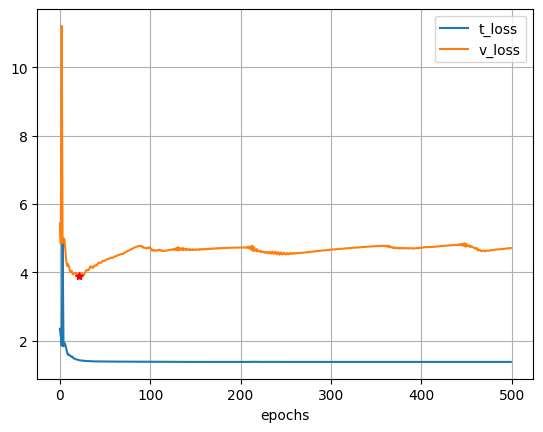

In [126]:
import numpy as np

ep_opt = np.argmin(np.asarray(valloss))
plt.plot([tloss for (tloss, _,_,_) in trainloss], label='t_loss')
plt.plot(valloss, label='v_loss')
plt.plot(ep_opt, valloss[ep_opt], 'r*')
plt.grid('on')
plt.xlabel('epochs')
plt.legend()
print(f'best val_loss = {valloss[ep_opt]} at epoch = {ep_opt}')
plt.show()

wandb.log({"best_val_loss": valloss[ep_opt], "best_epoch": ep_opt})

In [127]:
torch.save({'epoch': 499,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'trainloss': trainloss[-1],
            'valloss': valloss[-1],},
            'best_lstm11_last.pt')

In [132]:
import numpy as np 

lstm_best = LSTM11(z_dim=32, h_dim=256, num_actions=len(tokens), hfc_dim=1024, num_layers=1)
lstm_best.to(device)
lstm_best.load_state_dict(torch.load('best_lstm11_last.pt')['model_state_dict'])

print(test_epoch(lstm_best,device,trainloader))
print(test_epoch(lstm_best,device,valloader))


1.3795816421508789
4.713580131530762


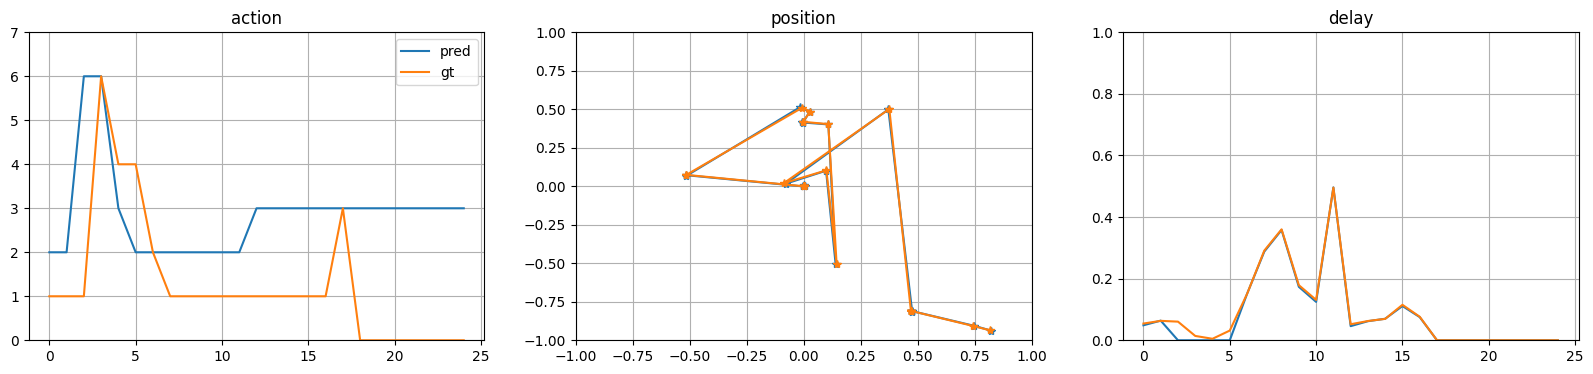

In [133]:
def viz(a, p, d, ib, label):
    a = a[ib].squeeze().detach().cpu().numpy()
    p = p[ib].squeeze().detach().cpu().numpy()
    d = d[ib].squeeze().detach().cpu().numpy()
    plt.subplot(131)
    plt.plot(a.argmax(axis=1), label=label)
    plt.ylim([0,len(tokens)])
    plt.grid("on")
    plt.title('action')
    plt.legend()
    plt.subplot(132)
    plt.plot(p[:,0], p[:,1], "-*", label=label)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid("on")
    plt.title('position')
    plt.subplot(133)
    plt.plot(d, label=label)
    plt.ylim([0,1])
    plt.grid("on")
    plt.title('delay')

with torch.no_grad():
    zb, (ab, pb, db) = next(iter(trainloader))
    
ib = 1
zb = zb.to(device)
ab = ab.to(device)
pb = pb.to(device)
db = db.to(device)
a_pred, p_pred, d_pred = lstm_best(zb)

plt.figure(figsize=(20,4))
viz(a_pred, p_pred, d_pred, ib, "pred")
viz(ab, pb, db, ib, "gt")
plt.show()

In [ ]:
def unnormalized(xtensor):
    return np.transpose((xtensor*0.5+0.5).numpy(), (1, 2, 0))

def denormalization(x_norm, max):
    return max/2*(x_norm + 1.0)

def detransform(actions, max):
    actions = denormalization(actions, max)
    return np.round(actions).astype('uint8')